# concrete.biopython, practical applications

**concrete.biopython** is a **FHE** library based on python [**biopython**](https://biopython.org/) library. It implements the same objects and functions when they are compatible with fhe.

In bioinformatics, the most basic object is the **sequence**. Sequences generally represent **DNA** and **RNA** strands, or **proteins** which are **amino acids** strands. Bioinformatics computations are most often processings of such sequences. This tutorial presents some basic processing algorithms on sequences, in **FHE**. Indeed, as data is often very sensitive in bioinformatics, using **FHE** guarantees end to end privacy of the data and of its processing.  

Some applications are inspired from this python bioinformatics [tutorial](https://github.com/mrdbourke/coursera_bioinformatics_and_genetic_algorithm_experiment/blob/master/coursera-bioinformatics-content-and-genetic-algorithm-experiment.ipynb). We will first see how to make reusable code to easily generate circuits that can be used for different applications. Then we will see the applications themselves. We will display beforehand the difficulty level of each application.



## I. Setting up FHE for practical applications

Before presenting the algorithms, we will set up some reusable code that will help us for each application later. Given a sequence processing function and a list biopython <span style="color:green">**Seq**</span> objects, our reusable code should allow to:

**i.** Preprocess the list of sequences so as to convert it into a single integer array that will be the circuit's input.  

**ii.** Generate automatically a circuit adapted to the length of our input and using a given sequence processing function.  

**iii.** Run the circuit and measure performance on given input.

### Imports
First of all, we need to import **numpy** and **concrete.fhe**, as well as <span style="color:green">**Seq**</span>  from **Bio.Seq**.
Then we import <span style="color:orange">**FheSeq**</span> from **concrete_biopython.FheSeq**, and also **SeqWrapper.**<span style="color:#5CC8FF">**SeqWrapper**</span> which will allow to interface the two librairies.

You can check out the quickstart tutorial presenting these objects in more details. Here, we will follow a similar route than in the quickstart to interface **Bio.Seq** and **concrete_biopython.FheSeq** objects.

In [22]:
import numpy as np
from concrete import fhe
from Bio.Seq import Seq, MutableSeq

import sys, os, time
sys.path.append(os.path.dirname(os.getcwd()))

from concrete_biopython.FheSeq import FheSeq, FheMutableSeq
from concrete_biopython.SeqWrapper import SeqWrapper

### i. Sequence preprocessing

As in the quickstart tutorial, we will need to convert <span style="color:green">**Seq**</span> objects from outside FHE to <span style="color:orange">**FheSeq**</span> objects inside the FHE circuit.  

For each practical application, we will have different numbers of <span style="color:green">**Seq**</span> objects to encrypt and process. In order to be able to reuse our code for these multiple applications, we can merge these sequences into one long sequence, so that our circuit takes only one input sequence every time.

Let's define a `concat_sequences` function that concatenates a list of sequences and returns the concatenated sequence, along with indices to be able to slice concatenated sequence back later. Let's also define the reverse function `slice_sequence` to slice back a long sequence into several sequences:

In [23]:
def concat_sequences(seqs):
    """
    Concatenate a list of Seq or FheSeq sequences, and records their indices as slice objects.
    """
    seq= seqs[0]
    index=len(seqs[0])
    slices=[slice(0,index)]
    for i in range(1, len(seqs)):
        seq += seqs[i] # Seq objects can be directly added
        slices.append(slice(index, index+len(seqs[i])))
        index+=len(seqs[i])
    return seq, slices

def slice_sequence(seq, slices):
    """
    Slice a long sequence into its original sub-sequences
    """
    seqs=[]
    index=0
    for ind in slices:
        seqs.append(seq[ind.start:ind.stop])
    return seqs

# Testing the functions
SEQ, INDICES = concat_sequences([Seq('AB'), Seq('C'), Seq('DEF')])
print(SEQ)
print(slice_sequence(SEQ, INDICES))

ABCDEF
[Seq('AB'), Seq('C'), Seq('DEF')]


### ii. Making a circuit factory

We want to make a circuit factory so that for each application later, we can simply provide a core sequence processing function and provide it to the factory that will generate a circuit from it. We will even wrap this circuit to be able to work with <span style="color:green">**Seq**</span> objects inputs instead of integer arrays inputs.

The core function will be named `process_sequence`, taking a sequence and returning the result of some processing algorithm. We want a function that can work on both clear or encrypted data, so we also provide it with the library **numpy** or **concrete.fhe** for when there are differences in the processing. For now, we define a simple processing function for the example, that outputs wether two sequences are identical. It slices the input sequence into sub-sequences, and then compares the two firsts.  

Then, let's make a `circuit_factory` returning a circuit compiled on a given sequence processing function, and adapted for a given input sequence: the inputset is adapted to the sequence length and to the letters present in the sequence, which allows faster and more precise FHE computations. Note that the integer array input `data` is first converted into a <span style="color:orange">**FheSeq**</span> objects so that the sequence processing function can work on it the same way it works on <span style="color:green">**Seq**</span> objects:

In [24]:
def process_sequence(seq):
    """
    Check wether the two first subsequences of the list are identical
    This is a dummy function for testing, we will redefine it for each application later
    """
    seqlist = slice_sequence(seq, INDICES)
    return seqlist[0]==seqlist[1]

def circuit_factory(seq, process_seq):
    """
    Return a circuit compiled on 'process_seq' adapted for the sequence 'seq'
    """
    compiler = fhe.Compiler(lambda data: process_seq(FheSeq(data)), {"data": "encrypted"})    
    return compiler.compile(
        inputset=[
        # Use SeqWrapper.maxInteger() to know the maximum integer that can be
        # used to represent a character in FheSeq obects
        np.random.randint(0, SeqWrapper.maxInteger()+1, size=(len(seq),))
        for _ in range(300)
        ],
        configuration=fhe.Configuration(
            enable_unsafe_features=True,
            use_insecure_key_cache=True,
            insecure_key_cache_location=".keys",
            dataflow_parallelize=False,
        ),
        verbose=False,
    )

# Test process_sequence
OUTPUT_PYTHON = process_sequence(SEQ)
print("Python: Are the first two sequences equal ?: ", OUTPUT_PYTHON)

Python: Are the first two sequences equal ?:  False


### iii. Running the circuit and measuring performance

As we wish to compare the performance of different circuit, we will use the `measure_time` function which will execute a function on given inputs and display the computation time.  

Then, we make a `circuit_wrapper` that allows to run a circuit onto a <span style="color:green">**Seq**</span> object, using the <span style="color:#5CC8FF">**SeqWrapper**</span>**.toIntegers** function. Here, we will need the wrapper to return **integer outputs**, but we could have converted them back into a <span style="color:green">**Seq**</span> object if needed using <span style="color:#5CC8FF">**SeqWrapper**</span>**.toSeq**. We measure and display the times for compiling, encrypting, and running.  

Finally, in order to keep reusing code, we can pack the actual making and running of a circuit in a function, along with printing the output and displaying computation time in `compute_fhe_output`:

In [25]:
def measure_time(function, descripton, *inputs):
    """
    Compute a function on inputs and return output along with duration
    """
    start = time.time()
    output = function(*inputs)
    end = time.time()
    print(f"|  {descripton} : {end-start:.2f} s  |")
    return output

def circuit_wrapper(circuit, seq):
    """
    Wrap a FHE circuit in order to input Bio.Seq objects
    """
    # Convert Seq object to integers with SeqWrapper.toIntegers
    integers = SeqWrapper.toIntegers(seq)
    # Run the circuit on integer inputs
    encrypted = measure_time(circuit.encrypt, 'Encrypting', integers)
    run = measure_time(circuit.run,'Running   ', encrypted)
    integer_output = circuit.decrypt(run)
    # Return the integers output
    return integer_output
    # Alternatively, one could return a Seq objects with: return SeqWrapper.toSeq(integer_output)
    
def compute_fhe_output(seq, process_seq, description, res=False):
    """
    Pack up the creation and running of a circuit,
    and display the result along with the computation times
    """
    # First print the description and a waiting message
    print(description)
    print("Computing ...", end="", flush=True)
    print("\r", end="")
    
    # Make computations and print output and time
    wrapped_circuit = measure_time(circuit_factory, 'Compiling ', seq, process_seq)
    output_fhe = circuit_wrapper(wrapped_circuit, seq)
    
    print('==> Result :', output_fhe, '\n')

    # In case we need the result
    if res:
        return output_fhe

That's it ! Before starting our first practical application, we can try out this code on our test sequence and processing function defined earlier, checking homomorphically wether the two first sequences of the list are identical:

In [26]:
# Compute our simple process_sequence function in FHE on our test sequence:
compute_fhe_output(SEQ, process_sequence, description='FHE: Are the first two sequences equal ?:')

FHE: Are the first two sequences equal ?:
|  Compiling  : 0.35 s  |
|  Encrypting : 0.00 s  |
|  Running    : 0.00 s  |
==> Result : 0 




## II. Computing the distance between two sequences

As a first application, we will compute in FHE the **distance between two sequences**. A distance between two sequences **A** and **B** is a function that measures their similarity and obeys the following conditions:
- If A = B, then *distance(A,B)=0*
- If A ≠ B, then *distance(A,B)>0*
- For all sequences A and B, *distance(A,B) = distance(B,A)*
- For all sequences A,B, and C, *distance(A,C) <= distance(A,B) + distance(B,C)*

Computing the distance between two biological sequences, for instance **DNA** strands, is often used in bioinformatics as a measure of similarity. We will see here the [**hamming distance**](https://en.wikipedia.org/wiki/Hamming_distance) and the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance).

### Hamming distance 

( difficulty level: *easy* )

The **hamming distance** between two sequences of **same length** is simply the number of positions where the two sequences are different. It is often used in bioinformatics to measure the similarity of biological sequences of same length such as **DNA** strands.  

Let's define the `hamming` function which computes this distance between two arrays. The `hamming_adapter` allows to adapt inputs from either <span style="color:green">**Seq**</span> or <span style="color:orange">**FheSeq**</span> objects:

In [64]:
def hamming(arr1, arr2):
    """
    Return the number of differences between arrays arr1 and arr2
    """
    if arr1.size != arr2.size:
        raise ValueError('arrays must have same size')
        
    return np.sum(arr1 != arr2)

def hamming_adapter(seq1, seq2):
    """
    Adapter for hamming distance of Seq objects
    Convert Seq or FheSeq objects into integer arrays
    """
    if isinstance(seq1, FheSeq):
        return hamming(seq1.toArray(),seq2.toArray())
    elif isinstance(seq1, Seq):
        return hamming(np.array(list(str(seq1))), np.array(list(str(seq2))))
    else:
        return NotImplemented

Let's measure the distance between two short strands of **DNA**, both in python and FHE:

In [21]:
S = Seq("AGGTTGGTAAAATGGTCCGTGGC")
T = Seq("ACCGTAATAAACGTGTCCGTTGG")

SEQ_H, INDICES_H = concat_sequences([S,T])

def process_sequence(seq):
    seqlist = slice_sequence(seq, INDICES_H)
    return hamming_adapter(seqlist[0],seqlist[1])

# run the circuit in python
OUTPUT_PYTHON = process_sequence(SEQ_H)
print('Python: Haming distance of S & T:', OUTPUT_PYTHON)

# run the circuit in FHE and compare the results
compute_fhe_output(SEQ_H, process_sequence, description='FHE: Haming distance of S & T:')


Python: Haming distance of S & T: 10
FHE: Haming distance of S & T:
|  Compiling  : 0.43 s  |
|  Encrypting : 0.14 s  |
|  Running    : 3.03 s  |
==> Result : 10 



The distance is relatively fast to compute in FHE because it is a simple algorithm.

### Levenshtein distance

( difficulty level: *medium* )

The **Levenshtein distance** between two sequences is a bit more complex to compute. It measures **the number of simple operations** needed to transform a sequence into another one. These three simple operations are the **deletion** of an element, the **addition** of an element, and the **swapping** of two different elements. Check out the pseudo-code algorithm at: [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance).

This distance is also sometimes used in bioinformatics to measure the similarity of biological sequences with different length.

Again, we define the `levenshtein` function in a recursive fashion (the recursion is in python, but the compiled graph will not be recursive in FHE), as well as a `levenshtein_adapter` to adapt inputs. Note that in `levenshtein` function, we use an **if** condition. While this is forbidden in FHE on encrypted variables, in this case the condition is allowed because it concerns the size of the arrays which is not encrypted.  

However, contrary to the original algorithm where the condition `(arr1[0] == arr2[0])` will stop the computation of the corresponding recursion branch if it is true, the FHE algorithm needs to run both branches of the computation. Indeed, the result of the condition being encrypted, both branches will run which will greatly slow the computation.

In [22]:
def min_two(x, y):
    """
    Return the minimum between a and b using a boolean mutliplication
    """    
    x_lt_y = x<y
    return x_lt_y*x + (1-x_lt_y)*y

def min_three(a, b, c):
    return min_two(a,min_two(b,c))

def levenshtein(arr1, arr2):
    """
    Compute the Levenshtein distance between two array objects
    """
    if arr2.size == 0:
        return fhe.ones(1)[0]*arr1.size
    elif arr1.size == 0:
        return fhe.ones(1)[0]*arr2.size
    else:
        iseq0 = (arr1[0] == arr2[0])
        lev1 = levenshtein(arr1[1:], arr2[1:])
        lev2 = levenshtein(arr1[1:], arr2)
        lev3 = levenshtein(arr1, arr2[1:])
        minlev = min_three(lev1, lev2, lev3)
        return iseq0*lev1 + (1-iseq0)*(1+minlev)

def levenshtein_adapter(seq1, seq2):
    """
    Adapter for levenshtein distance of sequence objects
    Convert Seq or FheSeq objects into integer arrays
    """
    if isinstance(seq1, FheSeq):
        return levenshtein(seq1.toArray(),seq2.toArray())
    elif isinstance(seq1, Seq):
        return levenshtein(np.array(list(str(seq1))), np.array(list(str(seq2))))
    else:
        return NotImplemented
    
S = Seq("ACGT")
T = Seq("CGTA")

SEQ_L, INDICES_L = concat_sequences([S,T])

def process_sequence(seq):
    seqlist = slice_sequence(seq, INDICES_L)
    return levenshtein_adapter(seqlist[0],seqlist[1])

OUTPUT_PYTHON = process_sequence(SEQ_L)
print('Python: Levenshtein distance of S & T:', OUTPUT_PYTHON)

Python: Levenshtein distance of S & T: 2


Let's test this distance on very small DNA strands inputs:

In [23]:
compute_fhe_output(SEQ_L, process_sequence, description='FHE: Levenshtein distance of S & T:')

FHE: Levenshtein distance of S & T:
|  Compiling  : 19.35 s  |
|  Encrypting : 0.24 s  |
|  Running    : 22.98 s  |
==> Result : 2 



The computation is relatively quite **long**. Why is that ?  

The function is quite complex compared to the hamming distance, and also it requires to run all conditional branches in the recursive computation. This makes the computation time grow exponentially with regard to the input length. Also, recall that we did earlier in `circuit_factory`:
```python
inputset=[
    np.random.randint(0, SeqWrapper.maxInteger()+1, size=(len(seq),))
    for _ in range(100)
],
```
This inputset is made with values ranging from `0` to `SeqWrapper.maxInteger()`, which gives the size of the total alphabet of possible letters encoded as integers in <span style="color:orange">**FheSeq**</span> objects. When we are dealing only with few letters, such as DNA/RNA letters, a lot of letters are unused, and so their encoding has a bigger bitwidth and complexity than necessary.

To improve the speed of both encryption and computation, we can specify to the class <span style="color:#5CC8FF">**SeqWrapper**</span> what alphabet we will be using in our sequences with <span style="color:#5CC8FF">**SeqWrapper**</span>**.setAlphabet**. This will optimize the integer representation to work only for the provided letters. In our case, we want to work only with **DNA** upper case letters:

In [24]:
# Reduce the alphabet to DNA/RNA uppercase letters
SeqWrapper.setAlphabet('ACGTU')

# Let's run the computation again (the SeqWrapper.maxInteger will be changed in circuit_factory ):
compute_fhe_output(SEQ_L, process_sequence, description='FHE: Levenshtein distance of S & T:')

# Reset alphabet
SeqWrapper.resetAlphabet()

FHE: Levenshtein distance of S & T:
|  Compiling  : 21.24 s  |
|  Encrypting : 0.05 s  |
|  Running    : 5.61 s  |
==> Result : 2 



As we can see, the encryption time and particularly the running time are better now. Be aware than setting an alphabet with <span style="color:#5CC8FF">**SeqWrapper**</span>**.setAlphabet** will affect the <span style="color:orange">**FheSeq**</span> internal representation which also uses the class <span style="color:#5CC8FF">**SeqWrapper**</span>, so if the new alphabet does not include protein letters for instance, the <span style="color:orange">**FheSeq**</span>.**translate** function will raise an error.


## III. Finding the origin of replication in a sequence

( difficulty level: *medium* )

As a second application, we will look in FHE for the [**origin of replication**](https://en.wikipedia.org/wiki/Origin_of_replication) in a DNA strand. The **origin of replication** (also called the **replication origin**) is a particular sequence in a genome at which **replication** is initiated, used when a cell divides. This area of the genome sometimes needs to be analyzed, but it needs to be found first.  

In most area of DNA genomes, there is an equal proportion of nucleotides **'A'** (adenine), **'C'** (cytosine), **'G'** (guanine) and **'T'** (thymine). However, around the **origin of replication**, the proportion of guanine and thymine (G and T) **is greater** than the proportion of adenine and cytosine (A et C). This particularity is helpful to find the approximate localisation of the origin of replication.  

In the function `minimum_skew` we take a look at the ratio between letter 'G' to letter 'C', to retrieve the location in the strand where this ratio is minimal. To that extent, we first create a lookup table to map letters 'G' to a 1 and letters 'C' to a -1, the other letters 'A' and 'T' being mapped to 0. Then, we sum up the values throughout the sequences, and keep the first index of the minimum value of this cumulated sum. We also return the whole cumulated sum array for plotting.

In [25]:
def minimum_skew(seq):
    """
    Return the index of the minimum skew in a sequence
    Note: Only the first index of minimum skew is returned
    """ 
    # First, create a lookup table to map G to 1 and C to -1
    if isinstance(seq, FheSeq):
        CG_integers = SeqWrapper.toIntegers(Seq('CG'))
        letter_table = [0]*(SeqWrapper.maxInteger()+1)
        letter_table[CG_integers[0]]=-1
        letter_table[CG_integers[1]]=1
        letter_table = fhe.LookupTable(letter_table)
        skew_counts = fhe.zeros(len(seq))
    elif isinstance(seq, Seq):
        letter_table = {'A':0, 'C':-1, 'G':1, 'T':0}
        skew_counts = np.zeros(len(seq)).astype('int')
    else:
        return NotImplemented
    
    # Then compute the cumulated sum and keep the first index of the minimum
    skew_counts[0] = letter_table[seq[0]]
    minimum = skew_counts[0]
    min_index = 0
    for i in range(1,len(seq)):
        # Compute cumulated sum
        skew_counts[i] = skew_counts[i-1] + letter_table[seq[i]]
        # and keep minimum
        ismin = (skew_counts[i]<minimum)
        minimum = min_two(skew_counts[i], minimum)
        min_index = i*ismin + min_index*(1-ismin)
        
    return min_index, skew_counts


As mentioned, the function will only output the first index where the minimum value is reached. This is a limitation of FHE. It is indeed not possible to retrieve an arbitrary number of locations in FHE, for instance to return a list with all indices where the minimum is reached. We could however return an array of the size of the sequence containing ones where the minimum is reached, or, with very extensive computations, containing the indices of the minimum followed by zeros.  

Another limitation here is the size of the sequence. If the size becomes too long, the values in `skew_counts` may become larger than the maximum capacity of FHE integers that have limited bitwidth. But this could be overcome with counting trick such as splitting the hundreds or thousands in a separate counter variable. 

Let's test our function on a clear sequence, and plot the cumulated sum of 'C' letters minus 'G' letters. Then we test it with encrypted data:

Python: The minimum skew is at index: 18


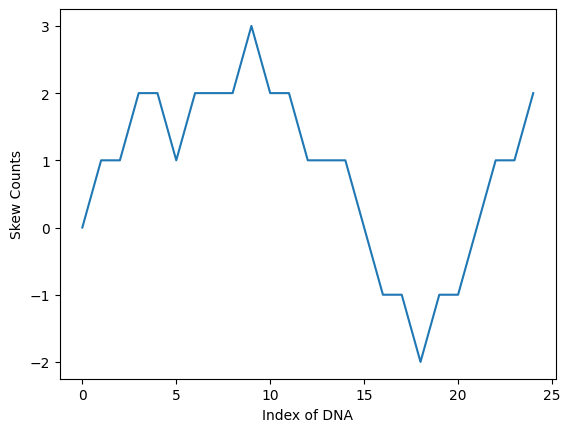

In [26]:
SEQ_O = Seq('AGTGACGTAGCACATCCACGAGGTG')

OUTPUT_PYTHON, skew_counts = minimum_skew(SEQ_O)
print('Python: The minimum skew is at index:', OUTPUT_PYTHON)

# Plot the skew_counts to check them out
import matplotlib.pyplot as plt
plt.plot(skew_counts)
plt.ylabel('Skew Counts')
_=plt.xlabel('Index of DNA')


In [27]:
def process_sequence(seq):
    return minimum_skew(seq)[0] # return only the minimum value for fhe

compute_fhe_output(SEQ_O, process_sequence, description='FHE: The minimum skew is at index:')

FHE: The minimum skew is at index:
|  Compiling  : 3.66 s  |
|  Encrypting : 0.47 s  |
|  Running    : 32.07 s  |
==> Result : 18 



## IV. Sorting sequences

### Comparing two sequences:

As we already saw, <span style="color:green">**Seq**</span> and <span style="color:orange">**FheSeq**</span> classes implement some operators such as **len(**seq**)**, seq**[i:j]**,  or s1**==**s2. They also implement the comparison operators s1 **>** s2, s1 **>=** s2 and their opposite s1 **<** s2, s1 **<=** s2.  

For the <span style="color:green">**Seq**</span> class, a sequence **A** is lower than another sequence **B** (noted *A<B*) if **A** is alphabetically lower than **B** (and not equal to B). The first character is compared first:  
- If *A[0] < B[0]* then *A < B*
- Else, if *A[0] > B[0]* then *A > B*
- Else, *A[0] = B[0]*, so the second character is compared, and so on.  

For instance, `Seq('AB')` is lower than `Seq('AC')`. Also, `Seq('AA')` is lower than the `Seq('AAA')` because the empty character at the end is considered alphabetically lower than all other characters. The <span style="color:orange">**FheSeq**</span> class works with the same principle. Comparing two sequences in alphabetical order is sometimes used inside bigger bioinformatics algorithms. If you need element wise comparison between <span style="color:orange">**FheSeq**</span> objects instead, use `A.toArray() > B.toArray()`.

### Ranking a list of sequences:

( difficulty level: *medium* )

With such comparison operators, we are able to sort a list of sequences. On clear data, it is possible to use `sorted(sequence_list)` to sort a list of sequences, but in FHE, this is impossible for sequences of different lenghts. Indeed, `sorted()` uses **if** conditions to order the sequences in a new **list** object. In FHE, because **if** conditions are forbidden, we cannot create a new ordered list. However, we can create an array where each index contains the rank of the sequence at this index.  

To do so, we can build a comparison matrix. Suppose our list of sequences is the following : `seqlist = ['CAA', 'AAB', 'CAA', 'AA', 'AAA']`, and we want an ascending ranking. In our comparison matrix, we will compute `comp_matrix[i,j] = seqlist[i]<seqlist[j]` when `i<j`(upper half), and `seqlist[i]>=seqlist[j]` equal to `1-comp_matrix[i,j]` when `j<i` (lower half).  

Then, we can sum up the results on each row to get how many other sequences are lower than the sequence of the row, which gives exactly the ranking of this sequence in the list. Note that even though two identical sequences are provided, they get each a different rank, which is preferable (this is because we used `seqlist[i]>=seqlist[j]` instead of `seqlist[i]>seqlist[j]`).

<div>
<img src="https://rcd-media.com/docs/fhe/tableau_sort.png" width="750"/>
</div>

In [28]:
def rank_sequences(seqlist, ascending=True):
    """
    Returns an array with the rank of each sequence in the list
    """
    n=len(seqlist)
    
    # Create a comparison matrix
    comp_matrix = fhe.zeros((n,n)) # this works in regular python as well
    
    # Fill the matrix with comparison results
    for i in range(0, n):
        for j in range(i+1, n):
            # Compute upper half of the matrix with seqlist[i]<seqlist[j]
            if ascending:
                comp_matrix[i,j] = (seqlist[i]<seqlist[j])
            else:
                comp_matrix[i,j] = (seqlist[i]>=seqlist[j])
                
            # Then fill the contrary to the lower half 
            comp_matrix[j,i] = 1-comp_matrix[i,j]
            
            # Note: 1-comp_matrix[i,j] is the same as seqlist[j]>=seqlist[i] (for ascending)
            # Using seqlist[j]>=seqlist[i] instead of seqlist[j]>seqlist[i]
            # will return a clear order, with different ranks even for
            # equal sequences. Also, this is faster.
            
    # now sum up each row to get a sorting rank for the sequences
    return np.sum(comp_matrix, axis=0)
            
     
def process_sequence(seq):
    seqlist = slice_sequence(seq, INDICES_S)
    return rank_sequences(seqlist)

Let's test this algorithm on the example sequence list:

In [29]:
# Test the sequence list of the example
SEQ1 = Seq('AA')
SEQ2 = Seq('AAA') # as mentioned earlier, SEQ2 is alphabetically greater than SEQ1
SEQ3 = Seq('AAB')
SEQ4 = Seq('CAA')
SEQ5 = Seq('CAA') # same a SEQ4, will be ranked after it

# Create a shuffled list, like in the example
seqlist = [SEQ5, SEQ3, SEQ4, SEQ1, SEQ2]
# Note: the expected ranks are thus: [5 3 4 1 2], or equally: [4 2 3 0 1]

# Test sorted in python to compare (remember this cannot work in FHE):
print('Sorted list:', sorted(seqlist))

# Concatenate the list
SEQ_S, INDICES_S = concat_sequences(seqlist)

# Test our algorithm in python
OUTPUT_PYTHON = process_sequence(SEQ_S)
print("\nThe ranks of sequences are :", OUTPUT_PYTHON)

Sorted list: [Seq('AA'), Seq('AAA'), Seq('AAB'), Seq('CAA'), Seq('CAA')]

The ranks of sequences are : [4 2 3 0 1]


In [30]:
compute_fhe_output(SEQ_S, process_sequence, description='FHE: The ranks of sequences are:')

FHE: The ranks of sequences are:
|  Compiling  : 1.92 s  |
|  Encrypting : 0.24 s  |
|  Running    : 2.60 s  |
==> Result : [4 2 3 0 1] 



In [31]:
# also test on a limited alphabet to compare
SeqWrapper.setAlphabet('ABCDEFG')
compute_fhe_output(SEQ_S, process_sequence, description='FHE: The ranks of sequences are:')
SeqWrapper.resetAlphabet()

The ranks of sequences are:
|  Compiling  : 1.77 s  |
|  Encrypting : 0.05 s  |
|  Running    : 0.63 s  |
==> Result : [4 2 3 0 1] 



Much faster !

### Sorting sequences of same length:

( difficulty level: *hard* )

We saw that in FHE, it is impossible to sort a list for sequences of different lengths. But for sequences of identical lengths (or with adjusted length as we will see), there is a very computationally intensive way of proceeding.  

When given a list `[a,b]` of two encrypted numbers **a** and **b**, we can sort them using the formula `sortedlist  = [ a*(a<b) + b*(b<a), a*(a>b) + b*(b>a) ]`. This formula uses what we can call a *boolean sum*. For two numbers, this is already computationally intensive, but it works. For a bigger list of numbers `numlist`, the same applies. Let's see how this can be done, using python for now:


In [32]:
# Sorting a list of numbers
numlist = [8,10,6,4,0,2]
rank = rank_sequences(numlist) # the algorithm also works for any list of camparable objects
n=len(numlist)

# To sort the numbers, we simple make a boolean sum of them all that only keeps the one with the correct rank
sortedlist = [ np.sum([numlist[k]*(i==rank[k]) for k in range(n)]) for i in range(n) ]
print('sorted :',sortedlist)

sorted : [0, 2, 4, 6, 8, 10]


For a lists of elements of length `n`, we need to compute `n*n` steps of `numlist[k]*(i==rank[k])` in addition to the ranking algorithm. But recall we want to sort sequences. We can do the same for sequences by also looping on the index `j` in each sequence. When sequences have different lengths, we will first equalize their lengths by appending empty characters at the end of the shortest ones with `adjust_lenghts`.

In [33]:
def adjust_lenghts(seqlist):
    """
    Append empty characters to short sequences
    so they all have the same length
    """
    lengths = [ len(s) for s in seqlist ]
    maxlen = np.max(lengths)
    newlist = []
    for s in seqlist:
        if len(s) < maxlen:
            if isinstance(s, FheSeq):
                s += FheSeq(fhe.zeros(maxlen-len(s)))
            elif isinstance(s, Seq):
                s += Seq('\0'*(maxlen-len(s)))
            else:
                return NotImplemented
        newlist.append(s)
    
    return newlist

def sort_sequences(seqlist, ascending=True):
    """
    Sort sequences
    """
    # Rank the sequences
    rank = rank_sequences(seqlist, ascending)
    
    # Adjust their length to be equal if needed
    seqlist = adjust_lenghts(seqlist)
    
    # Create a new list to hold the result
    n=len(seqlist)
    m=len(seqlist[0])
    sorted_list = []
    
    lib = fhe if isinstance(seqlist[0], FheSeq) else np
    
    # Fill the array with a boolean sum of all sequences at each row
    for i in range(n): # i is the index of the sequence in the sorted list
        i_eq_rank_k = rank==i
        sorted_array = lib.zeros(m) if lib is fhe else ''
        for j in range(m): # j is the index of the letter in the sequence
            if lib is fhe:
                # k is the index of a sequence in the unsorted list
                # we could also put seqlist inside a 2d array and use a dot product here
                sorted_array[j] = np.sum( [seqlist[k][j]*i_eq_rank_k[k] for k in range(n)] )
            else:
                for k in range(n):
                    sorted_array += seqlist[k][j]*int(i_eq_rank_k[k])
        
        # Create sequence object from this array
        if lib is fhe:
            sorted_list.append(FheSeq(sorted_array))
        else:
            sorted_list.append(Seq(sorted_array))

    # Return the list of sorted (adjusted) sequences
    return sorted_list


Now, we want to make again a `process_sequence` that will work both in python and FHE. Because `sort_sequences` returns a list of sequences, we will need to concatenate them again in FHE and return an array so it can be decrypted.

In [34]:
# Test the same sequence list
SEQ1 = Seq('AA')
SEQ2 = Seq('AAA')
SEQ3 = Seq('AAB')
SEQ4 = Seq('CAA')
SEQ5 = Seq('CAA')

seqlist = [SEQ5, SEQ3, SEQ4, SEQ1, SEQ2]
SEQ_S, INDICES_S = concat_sequences(seqlist)

def process_sequence(seq):
    seqlist = slice_sequence(seq, INDICES_S)
    sorted_list = sort_sequences(seqlist)
    if isinstance(seq, FheSeq):
        newseq, _ = concat_sequences(sorted_list)
        return newseq.toArray()
    elif isinstance(seq, Seq):
        return sorted_list
    else:
        return NotImplemented
    
OUTPUT_PYTHON = process_sequence(SEQ_S)
print('The sorted list of sequences is:\n', OUTPUT_PYTHON)

The sorted list of sequences is:
 [Seq('AA '), Seq('AAA'), Seq('AAB'), Seq('CAA'), Seq('CAA')]


In [35]:
def slice_sequence_n(seq, n):
    """
    Slice a sequence into n subsequences of equal size
    """
    seqs=[]
    index=0
    length = len(seq)//n
    while index < len(seq):
        seqs.append(seq[index:index+length])
        index+=length
    return seqs

# test again on a limited alphabet to be faster
SeqWrapper.setAlphabet('ABCDEFG')
sorted_seq = compute_fhe_output(SEQ_S, process_sequence, description='The sorted sequences as array is:',res=True)
OUTPUT_FHE = [SeqWrapper.toSeq(s) for s in slice_sequence_n(sorted_seq, len(seqlist))]
print('The sorted list of sequences is:\n', OUTPUT_FHE)

SeqWrapper.resetAlphabet()

The sorted sequences as array is:
|  Compiling  : 4.13 s  |
|  Encrypting : 0.05 s  |


|  Running    : 4.46 s  |
==> Result : [1 1 0 1 1 1 1 1 2 3 1 1 3 1 1] 

The sorted list of sequences is:
 [Seq('AA '), Seq('AAA'), Seq('AAB'), Seq('CAA'), Seq('CAA')]


## V. Aligning sequences

Sequence alignment algorithms are extensively employed in the field of bioinformatics to identify patterns of similarity between sequences. These algorithms come in two main types: local and global alignment. Local alignment algorithms are designed to discover optimal local matches between two sequences, such as pinpointing specific gene segments within longer gene sequences. Conversely, global alignment algorithms strive to find the best alignment across the entire length of sequences, making them suitable for comparing different versions of the same gene, for example.

### Smith-Waterman algorithm

( difficulty level: hard )

The Smith-Waterman algorithm is a local alignement algorithm. The idea is to 

In [140]:
def max_list(l, strictly_gt=True):
    """
    Return the maximum value in a list using boolean mutliplication,
    along with the argmax (the index of the maximum)
    
    strictly_gt: set to True will return the first maximum found in case there are
    several identical values, while set to False will return the last maximum
    """
    maxval = l[0]
    argmax = 0
    for i in range(1, len(l)):
        is_gt = l[i]>maxval if strictly_gt else l[i]>=maxval
        maxval = is_gt*l[i] + (1-is_gt)*maxval
        argmax = is_gt*i + (1-is_gt)*argmax
    
    return maxval, argmax

# Assigning the constants for the scores
# These can be changed depending on what alignement we are looking for
class Score:
    MATCH = 1
    MISMATCH = -1
    GAP = -1

# Assigning the constant values for the traceback
class Trace:
    STOP=0
    LEFT=1
    UP=2
    DIAG=3

def smith_waterman(seq1, seq2, strictly_gt=True):
    """
    Returns the Smith Waterman local alignment of two sequences
    
    strictly_gt=True will favor shorter, more exact sequences
    while strictly_gt=False will favor longer, less exact sequences
    """    
    # Generating the empty matrices for storing scores and tracing
    row = len(seq1) + 1
    col = len(seq2) + 1
    matrix = fhe.zeros((row, col))
    tracing_matrix = fhe.zeros((row, col))
    
    # set variables depending on python or FHE run:
    if isinstance(seq1, FheSeq):
        zero_val = fhe.zeros(1)[0]
        empty_char =  SeqWrapper.LETTERS_TO_INTEGERS['\0']
        gap_char = SeqWrapper.LETTERS_TO_INTEGERS['-']
        make_empty_seq = lambda x: FheMutableSeq(fhe.zeros(x))
    elif isinstance(seq1, Seq):
        zero_val = 0
        empty_char = '\0'
        gap_char = '-'
        make_empty_seq = lambda x: MutableSeq('\0'*x)        
    else:
        return NotImplemented
        
    # Initialising the variables to find the highest scoring cell
    max_score = max_i = max_j = -1
    
    # Calculating the scores for all cells in the matrix
    for i in range(1, row):
        for j in range(1, col):
        # Note: we loop on j for clarity here, but it would be
        # faster to compute the whole column at once with tensors
        
            # Calculating the diagonal score (match score)
            is_eq = seq1[i - 1] == seq2[j - 1]
            match_value = Score.MATCH * is_eq + Score.MISMATCH* (1-is_eq)
            diagonal_score = matrix[i - 1, j - 1] + match_value
            
            # Calculating the vertical gap score
            vertical_score = matrix[i - 1, j] + Score.GAP
            
            # Calculating the horizontal gap score
            horizontal_score = matrix[i, j - 1] + Score.GAP
            
            # Taking the local highest score and where it comes from
            value_list = [zero_val, horizontal_score, vertical_score, diagonal_score]
            matrix[i, j], tracing_matrix[i, j] = max_list(value_list, strictly_gt)
            # if some scores are identical and are the maximum value, the value tracing_matrix will
            # depend on the parameter strictly_gt (see max_list function)
            # tracing_matrix[i, j] = 0, 1, 2 or 3 means STOP, LEFT, UP or DIAG
                
            # Tracking the cell with the global maximum score
            is_ge = matrix[i, j] >= max_score
            not_is_ge = (1-is_ge)
            max_i = max_i * not_is_ge + i * is_ge
            max_j = max_j * not_is_ge + j * is_ge
            max_score = max_score * not_is_ge + matrix[i, j] * is_ge       
    
    # Initialising the variables for tracing
    len_out = max(row,col)-1
    aligned_seq1 = make_empty_seq(len_out)
    aligned_seq2 = make_empty_seq(len_out)
    ind_ij = fhe.zeros((row, col))
    
    # Tracing and computing the pathway with the local alignment from the global maximum up
    #  while tracing_matrix[max_i, max_j] != Trace.STOP:
    for k in reversed(range(len_out)):

        # select value in tracing_matrix at index max_i, max_j:
        ind_i = np.arange(row)==max_i
        ind_j = np.arange(col)==max_j
        
        for i in range(1, row):
            for j in range(1, col):
                ind_ij[i,j] = ind_i[i] & ind_j[j] # using & for binary is faster than *
        
        V = np.sum(tracing_matrix*ind_ij)

        VSTOP = (V==Trace.STOP)*1
        VLEFT = (V==Trace.LEFT)*1
        VUP = (V==Trace.UP)*1
        VDIAG = (V==Trace.DIAG)*1
        VLEFT_or_VDIAG = VLEFT + VDIAG
        VUP_or_VDIAG = VUP + VDIAG        
        # Note: the *1 is just for pure python, to convert booleans into ints
        
        # select value in seq1 at encrypted index max_i - 1:
        v1 = seq1[max_i-1]
        # Note: we accessed seq1 with an encrypted index max_i-1, this is allowed by the FheSeq class
        # but it is computationally expensive, see FheSeq.__getitem__ function 
                
        current_aligned_char1 = (VUP_or_VDIAG)*v1 + VLEFT*gap_char + VSTOP*empty_char;
        # Note: in FHE, one should make as few multiplications as possible for speed purpose,
        # that's why we regrouped VDIAG + VUP here
        
        # select value in seq2 at encrypted index max_j - 1:
        v2 = seq2[max_j-1]
        current_aligned_char2 = (VLEFT_or_VDIAG)*v2 + VUP*gap_char + VSTOP*empty_char; 
        
        max_i = max_i - (VUP_or_VDIAG)
        max_j = max_j - (VLEFT_or_VDIAG)
        
        aligned_seq1[k] = current_aligned_char1
        aligned_seq2[k] = current_aligned_char2

    return aligned_seq1, aligned_seq2


Note that it is possible to access FheSeq values at encrypted index. It uses a trick, the same we used to select the value in the matrix, but it is very slow to process compared to unencrypted indexing. The algorithm is normally in O(mn), but here, because of this in the second loop, it is in O(p^3) where p=max(m,n)

try different combinations of substitution matrices and gap penalties.

In [141]:
# Test the same sequence list
SEQ1 = Seq('AG'+'TAGGCCGTTTAGCCAGTGGA'+'GTTGAGCTA'+'AG')
SEQ2 = Seq('AACC'+  'TAAGCCGTTTAGCCAGTGG'+ 'GTTAAGCTA')

SEQ1 = Seq('GATTACAGG')
SEQ2 = Seq('GATTACA')

seqlist = [SEQ1, SEQ2]
SEQ_S, INDICES_S = concat_sequences(seqlist)

def process_sequence(seq):
    seqlist = slice_sequence(seq, INDICES_S)
    if isinstance(seq, FheSeq):
        aligned_seq1, aligned_seq2 = smith_waterman(seqlist[0],seqlist[1])
        newseq, _ = concat_sequences([aligned_seq1, aligned_seq2])
        return newseq.toArray()
    elif isinstance(seq, Seq):
        aligned_seq1, aligned_seq2 = smith_waterman(seqlist[0], seqlist[1])
        return [Seq(aligned_seq1), Seq(aligned_seq2)]
    else:
        return NotImplemented
    
OUTPUT_PYTHON = process_sequence(SEQ_S)
print('The aligned sequences are:\n', OUTPUT_PYTHON)

The aligned sequences are:
 [Seq('  ATTACA'), Seq('  ATTACA')]


In [29]:
SeqWrapper.setAlphabet('ACGT-')
aligned_seqs = compute_fhe_output(SEQ_S, process_sequence, description='Smith-Waterman',res=True)
len_out = max(len(SEQ1), len(SEQ2))+1
aligned_seq1 = SeqWrapper.toSeq(aligned_seqs[0:len_out])
aligned_seq2 = SeqWrapper.toSeq(aligned_seqs[len_out:])
print('The aligned sequences are:\n', aligned_seq1, aligned_seq2)

SeqWrapper.resetAlphabet()

Smith-Waterman
|  Compiling  : 44.85 s  |
|  Encrypting : 4.89 s  |
|  Running    : 9.32 s  |
==> Result : [0 0 0 0 0 4 0 0 0 0 0 4] 

The aligned sequences are:
      G      G


KeySetCache: miss, regenerating .keys/5366286837612876716/0_0


Basic scoring schemes

The simplest scoring schemes simply give a value for each match, mismatch and indel. The step-by-step guide above uses match = 1, mismatch = −1, indel = −2. Thus the lower the alignment score the larger the edit distance, for this scoring system one wants a high score. Another scoring system might be:

    Match = 1
    Indel = -2
    Mismatch = -1

For this system the alignment score will represent the edit distance between the two strings. Different scoring systems can be devised for different situations, for example if gaps are considered very bad for your alignment you may use a scoring system that penalises gaps heavily, such as:

    Match = 1
    Indel = -1
    Mismatch = -2

Similarity matrix
More complicated scoring systems attribute values not only for the type of alteration, but also for the letters that are involved. For example, a match between A and A may be given 1, but a match between T and T may be given 4. Here (assuming the first scoring system) more importance is given to the Ts matching than the As, i.e. the Ts matching is assumed to be more significant to the alignment. This weighting based on letters also applies to mismatches. 

(4, 2)


In [130]:
# Assigning the constants for the scores
# These can be changed depending on what alignement we are looking for
class Score:
    MATCH = 1
    MISMATCH = -1
    GAP = -1

# Assigning the constant values for the traceback (not stopping here)
class Trace:
    LEFT = 0 
    UP = 1
    DIAG = 2

def needleman_wunsch(seq1, seq2, strictly_gt=False):
    """
    Returns the Needleman Wunsch global alignment of two sequences
    
    strictly_gt=True will favor ????
    while strictly_gt=False will ????
    """    
    # Generating the empty matrices for storing scores and tracing
    row = len(seq1) + 1
    col = len(seq2) + 1
    matrix = fhe.zeros((row, col))
    tracing_matrix = fhe.zeros((row, col))
    
    # initialize the first row and col of the matrix
    matrix[:,0] = -1*np.arange(row)
    matrix[0,:] = -1*np.arange(col)
    
    # set variables depending on python or FHE run:
    if isinstance(seq1, FheSeq):
        gap_char = SeqWrapper.LETTERS_TO_INTEGERS['-']
        make_empty_seq = lambda x: FheMutableSeq(fhe.zeros(x))
    elif isinstance(seq1, Seq):
        gap_char = '-'
        make_empty_seq = lambda x: MutableSeq('\0'*x)        
    else:
        return NotImplemented
        
    # Initialising the variables to find the highest scoring cell
    max_score = max_i = max_j = -1
    
    # Calculating the scores for all cells in the matrix
    for i in range(1, row):
        for j in range(1, col):
        # Note: we loop on j for clarity here, but it would be
        # faster to compute the whole column at once with tensors
        
            # Calculating the diagonal score (match score)
            is_eq = seq1[i - 1] == seq2[j - 1]
            match_value = Score.MATCH * is_eq + Score.MISMATCH* (1-is_eq)
            diagonal_score = matrix[i - 1, j - 1] + match_value
            
            # Calculating the vertical gap score
            vertical_score = matrix[i - 1, j] + Score.GAP
            
            # Calculating the horizontal gap score
            horizontal_score = matrix[i, j - 1] + Score.GAP
            
            # Taking the local highest score and where it comes from
            value_list = [horizontal_score, vertical_score, diagonal_score]
            matrix[i, j], tracing_matrix[i, j] = max_list(value_list, strictly_gt)
            # if some scores are identical and are the maximum value, the value tracing_matrix will
            # depend on the parameter strictly_gt (see max_list function)
            # ?????????????????????????????????????????????
                        # ?????????????????????????????????????????????
            # tracing_matrix[i, j] = 0, 1, 2 means LEFT, UP or DIAG
                
            # No tracking of the cell with the global maximum score here
 
    print(matrix)
    
    # Initialising the variables for tracing
    len_out = max(row,col)-1
    aligned_seq1 = make_empty_seq(len_out)
    aligned_seq2 = make_empty_seq(len_out)
    ind_ij = fhe.zeros((row, col))
    
    # Tracing and computing the pathway with the local alignment from the bottom-left up
    max_i = row-1
    max_j = col-1
    
    # select the starting value in tracing_matrix at index max_i, max_j (unencrypted for now)
    V = tracing_matrix[max_i, max_j]
        
    for k in reversed(range(len_out)):

        VLEFT = (V==Trace.LEFT)*1
        VUP = (V==Trace.UP)*1
        VDIAG = (V==Trace.DIAG)*1
        VLEFT_or_VDIAG = VLEFT + VDIAG
        VUP_or_VDIAG = VUP + VDIAG
        # Note: the *1 is just for pure python, to convert booleans into ints
        
        # select value in seq1 at encrypted index max_i - 1:
        v1 = seq1[max_i-1]
        # Note: we accessed seq1 with an encrypted index max_i-1, this is allowed by the FheSeq class
        # but it is computationally expensive, see FheSeq.__getitem__ function 
                
        current_aligned_char1 = (VUP_or_VDIAG)*v1 + VLEFT*gap_char;
        # Note: in FHE, one should make as few multiplications as possible for speed purpose,
        # that's why we regrouped VDIAG + VUP here
        
        # select value in seq2 at encrypted index max_j - 1:
        v2 = seq2[max_j-1]
        current_aligned_char2 = (VLEFT_or_VDIAG)*v2 + VUP*gap_char; 
        
        max_i = max_i - (VUP_or_VDIAG)
        max_j = max_j - (VLEFT_or_VDIAG)
        
        aligned_seq1[k] = current_aligned_char1
        aligned_seq2[k] = current_aligned_char2
        
        # select value in tracing_matrix at new indices max_i, max_j:
        ind_i = np.arange(row)==max_i
        ind_j = np.arange(col)==max_j
        
        if k == 0: # no need to compute the last one
            break
            
        for i in range(1, row):
            for j in range(1, col):
                ind_ij[i,j] = ind_i[i] & ind_j[j] # using & for binary is faster than *
        
        V = np.sum(tracing_matrix*ind_ij)      

    return aligned_seq1, aligned_seq2

In [135]:
def similarity_score(seq1, seq2):
    """
    Compute the number of identical characters in two Seq sequences objects
    """
    nequal = 0
    for i in range(min(len(seq1), len(seq2))):
        nequal += 1 if seq1[i]==seq2[i] else 0
    return nequal

SEQ1 = Seq('ATTACAG')
SEQ2 = Seq('GGATTAC')

#SEQ1 = Seq('AGT')
#SEQ2 = Seq('AT')

seqlist = [SEQ1, SEQ2]
SEQ_S, INDICES_S = concat_sequences(seqlist)

def process_sequence(seq):
    seqlist = slice_sequence(seq, INDICES_S)
    if isinstance(seq, FheSeq):
        aligned_seq1, aligned_seq2 = needleman_wunsch(seqlist[0],seqlist[1])
        newseq, _ = concat_sequences([aligned_seq1, aligned_seq2])
        return newseq.toArray()
    elif isinstance(seq, Seq):
        aligned_seq1, aligned_seq2 = needleman_wunsch(seqlist[0], seqlist[1])
        return [Seq(aligned_seq1), Seq(aligned_seq2)]
    else:
        return NotImplemented
    
OUTPUT_PYTHON = process_sequence(SEQ_S)
print('Similarity score before alignment :', similarity_score(SEQ1, SEQ2) )
print('The aligned sequences are:\n', OUTPUT_PYTHON)
print('Similarity score after alignement :', similarity_score(*OUTPUT_PYTHON))

[[ 0 -1 -2 -3 -4 -5 -6 -7]
 [-1 -1 -2 -1 -2 -3 -4 -5]
 [-2 -2 -2 -2  0 -1 -2 -3]
 [-3 -3 -3 -3 -1  1  0 -1]
 [-4 -4 -4 -2 -2  0  2  1]
 [-5 -5 -5 -3 -3 -1  1  3]
 [-6 -6 -6 -4 -4 -2  0  2]
 [-7 -5 -5 -5 -5 -3 -1  1]]
Similarity score before alignment : 1
The aligned sequences are:
 [Seq('ATTACAG'), Seq('ATTAC--')]
Similarity score after alignement : 5


In [ ]:
SEQ1 = Seq('GCATGCG')
SEQ2 = Seq('GATTACA')

seqlist = [SEQ1, SEQ2]
SEQ_S, INDICES_S = concat_sequences(seqlist)


SeqWrapper.setAlphabet('ACGT-')
aligned_seqs = compute_fhe_output(SEQ_S, process_sequence, description='Smith-Waterman',res=True)
len_out = max(len(SEQ1), len(SEQ2))+1
aligned_seq1 = SeqWrapper.toSeq(aligned_seqs[0:len_out])
aligned_seq2 = SeqWrapper.toSeq(aligned_seqs[len_out:])
print('The aligned sequences are:\n', aligned_seq1, aligned_seq2)

SeqWrapper.resetAlphabet()